In this colab notebook,
1. we will be exploring the concept of Image Classification without Image Augmentation.
2. We will classify images of dogs and cats.
3. We will build an Image classifier using tf.keras.Sequential
4. We will be loading the data using tf.keras.preprocessing.image.ImageDataGenerator

---

In [1]:
# Importing external libraries
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

In [2]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [3]:
import logging
logger = tf.get_logger()
logger.setLevel(logging.ERROR)

Data Loading
---

*   We will be using filtered version of Dogs vs. Cats dataset from Kaggle
*   For this, we will be using ImageDataGenerator to read data from disk i.e. we will directly download the dataset from url an unzip into Colab filesystem.



In [4]:
url = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'
zip_dir = tf.keras.utils.get_file('cats_and_dogs_filterted.zip', origin=url, extract=True)

68606236/68606236 [==============================] - 2s 0us/step


In [5]:
# Listing the directories
zip_dir_base = os.path.dirname(zip_dir)
!find $zip_dir_base -type d -print

/root/.keras/datasets
/root/.keras/datasets/cats_and_dogs_filtered
/root/.keras/datasets/cats_and_dogs_filtered/train
/root/.keras/datasets/cats_and_dogs_filtered/train/cats
/root/.keras/datasets/cats_and_dogs_filtered/train/dogs
/root/.keras/datasets/cats_and_dogs_filtered/validation
/root/.keras/datasets/cats_and_dogs_filtered/validation/cats
/root/.keras/datasets/cats_and_dogs_filtered/validation/dogs


In [6]:
# Assigning variables to proper path  directories for training and validation sets

base_dir = os.path.join(os.path.dirname(zip_dir), 'cats_and_dogs_filtered')
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

train_cats_dir = os.path.join(train_dir, 'cats')  # directory with our training cat pictures
train_dogs_dir = os.path.join(train_dir, 'dogs')  # directory with our training dog pictures
validation_cats_dir = os.path.join(validation_dir, 'cats')  # directory with our validation cat pictures
validation_dogs_dir = os.path.join(validation_dir, 'dogs')  # directory with our validation dog pictures

Exploratory Data Analysis
---



In [7]:
# Checking the shape of data

num_cats_tr = len(os.listdir(train_cats_dir))
num_dogs_tr = len(os.listdir(train_dogs_dir))

num_cats_val = len(os.listdir(validation_cats_dir))
num_dogs_val = len(os.listdir(validation_dogs_dir))

total_train = num_cats_tr + num_dogs_tr
total_val = num_cats_val + num_dogs_val

In [8]:
print('total training cat images:', num_cats_tr)
print('total training dog images:', num_dogs_tr)

print('total validation cat images:', num_cats_val)
print('total validation dog images:', num_dogs_val)
print("--")
print("Total training images:", total_train)
print("Total validation images:", total_val)

total training cat images: 1000
total training dog images: 1000
total validation cat images: 500
total validation dog images: 500
--
Total training images: 2000
Total validation images: 1000



Model Development : Setting Model Params and Pre-processing Data
---



In [9]:
BATCH_SIZE = 100  # Number of training examples to process before updating our models variables
IMG_SHAPE  = 150  # Our training data consists of images with width of 150 pixels and height of 150 pixels

Pre-Processing and Data Preparation
---
In order for the images to be fed to the convolution nertwork, we need to convert the images to floating- point tensors. The steps involved in converting the images are:
1. Reading the image from disk
2. Dcoding the content of images and converting them to proper grid format as per RGB content.
3. Converting them to floating-point tensors.
4. Rescaling the tensors from values b/w 0-255 to values b/w 0-1. We need to follow this step because NN prefers to deal with small input values.


In [10]:
train_image_generator      = ImageDataGenerator(rescale=1./255)  # Generator for our training data
validation_image_generator = ImageDataGenerator(rescale=1./255)  # Generator for our validation data


After defining our generators for training and validation images,
flow_from_directory method will load images from the disk,
apply rescaling, and resize them using single line of code.



In [11]:
train_data_gen = train_image_generator.flow_from_directory(batch_size=BATCH_SIZE,
                                                           directory=train_dir,
                                                           shuffle=True,
                                                           target_size=(IMG_SHAPE,IMG_SHAPE), #(150,150)
                                                           class_mode='binary')

Found 2000 images belonging to 2 classes.


In [12]:
val_data_gen = validation_image_generator.flow_from_directory(batch_size=BATCH_SIZE,
                                                              directory=validation_dir,
                                                              shuffle=False,
                                                              target_size=(IMG_SHAPE,IMG_SHAPE), #(150,150)
                                                              class_mode='binary')

Found 1000 images belonging to 2 classes.


Visualizing Train Images
---

In [13]:
sample_training_images, _ = next(train_data_gen)

In [14]:
# This function will plot images in the form of a grid with 1 row and 5 columns where images are placed in each column.
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow(img)
    plt.tight_layout()
    plt.show()

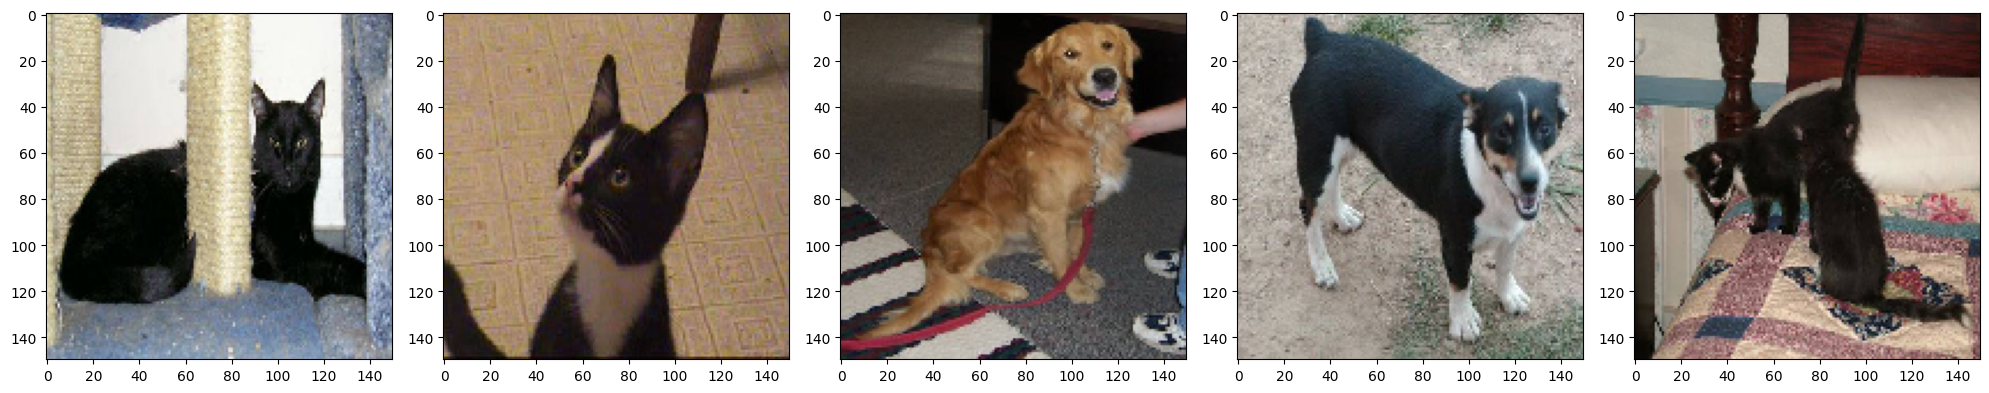

In [15]:
plotImages(sample_training_images[:5])  # Plot images 0-4

Model Development
---

The model consists of four convolution blocks with a max pool layer in each of them. Then we have a fully connected layer with 512 units, with a relu activation function. The model will output class probabilities for two classes — dogs and cats — using softmax.

In [16]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),

    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(2)
])

Compiling the Model
---


We will use the adam optimizer. Since we output a softmax categorization, we'll use sparse_categorical_crossentropy as the loss function. We would also like to look at training and validation accuracy on each epoch as we train our network, so we are passing in the metrics argument.

In [17]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [18]:
# Looking at all the layers of network
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 74, 74, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 36, 36, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 34, 34, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 17, 17, 128)      0

Model Training
---
Since our batches are coming from a generator (ImageDataGenerator), we'll use fit_generator instead of fit.

In [19]:
EPOCHS = 100
history = model.fit_generator(
    train_data_gen,
    steps_per_epoch=int(np.ceil(total_train / float(BATCH_SIZE))),
    epochs=EPOCHS,
    validation_data=val_data_gen,
    validation_steps=int(np.ceil(total_val / float(BATCH_SIZE)))
)

<ipython-input-19-d70e0a339f06>:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


Epoch 1/100
20/20 [==============================] - 23s 508ms/step - loss: 0.7416 - accuracy: 0.4965 - val_loss: 0.6914 - val_accuracy: 0.5010
Epoch 2/100
20/20 [==============================] - 10s 531ms/step - loss: 0.6938 - accuracy: 0.4940 - val_loss: 0.6925 - val_accuracy: 0.5000
Epoch 3/100
20/20 [==============================] - 10s 488ms/step - loss: 0.6922 - accuracy: 0.5175 - val_loss: 0.6881 - val_accuracy: 0.5320
Epoch 4/100
20/20 [==============================] - 10s 493ms/step - loss: 0.6870 - accuracy: 0.5365 - val_loss: 0.6807 - val_accuracy: 0.5510
Epoch 5/100
20/20 [==============================] - 9s 451ms/step - loss: 0.6729 - accuracy: 0.5745 - val_loss: 0.6686 - val_accuracy: 0.5750
Epoch 6/100
20/20 [==============================] - 9s 453ms/step - loss: 0.6544 - accuracy: 0.6030 - val_loss: 0.6447 - val_accuracy: 0.6030
Epoch 7/100
20/20 [==============================] - 10s 500ms/step - loss: 0.6340 - accuracy: 0.6245 - val_loss: 0.6159 - val_accuracy: 0

Visualizing Training Results
----

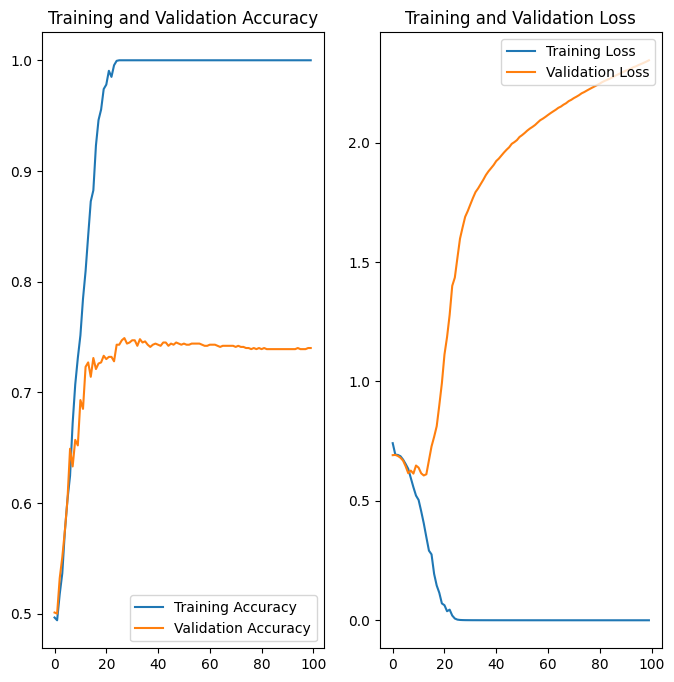

In [20]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.savefig('./foo.png')
plt.show()



As we can see from the plots, training accuracy and validation accuracy are off by large margin and our model has achieved only around ~74% accuracy on the validation set.

This is a clear indication of overfitting. Once the training and validation curves start to diverge, our model has started to memorize the training data and is unable to perform well on the validation data.
